#### I have now generated my object containing all my cleaned data, prior to hvg, saved as NR_cleandata.h5ad
##### This notebook will perform from hvg to integration on this object, and then comparison of pre and post integration data 


# Set up workspace:

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce
from matplotlib.pyplot import rc_context

In [2]:
#show current directory 
os.getcwd()
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

Print software versions:

In [3]:
sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [4]:
ddl.logging.print_header()

dandelion==0.3.8 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.2 networkx==3.3 scipy==1.14.0


Set plotting parameters

In [5]:
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [6]:
#read in data
NR_clean = sc.read_h5ad("NR_cleandata.h5ad") 

# pre-hvg to integration of NR_clean

In [7]:
NR_clean

AnnData object with n_obs × n_vars = 498382 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

### Identify highly variable genes

In [8]:
# (Expects logarithimised data)
sc.pp.highly_variable_genes(NR_clean, min_mean=0.0125, max_mean=3, min_disp=0.5)
NR_clean

AnnData object with n_obs × n_vars = 498382 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [9]:
#set hidden slot
NR_clean.raw = NR_clean

In [10]:
#to get number of HV genes
print(NR_clean.var.highly_variable.sum())

1268


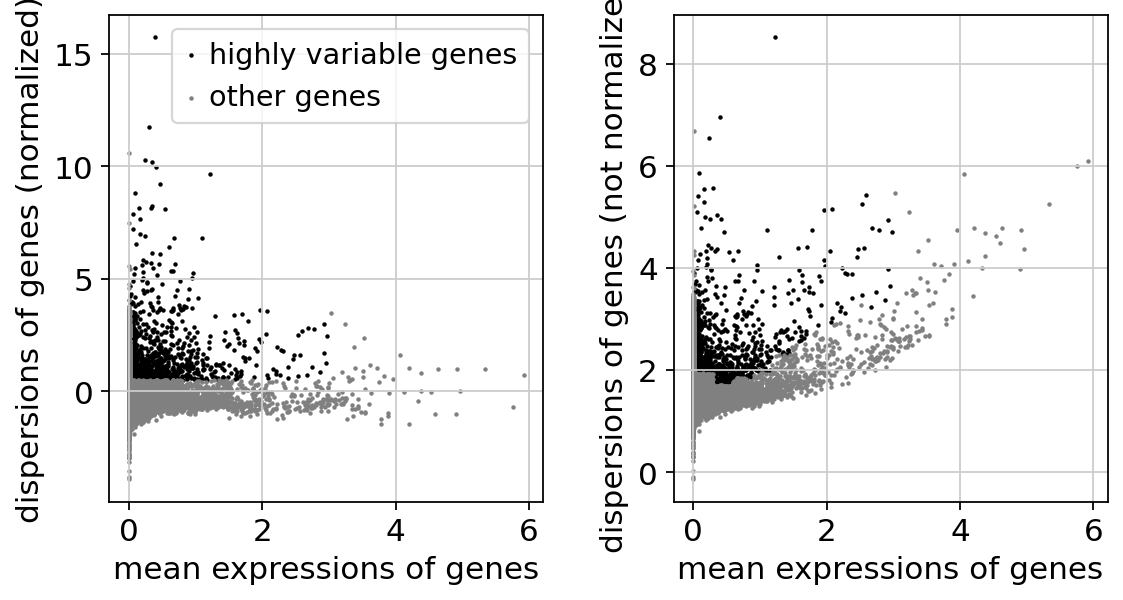

In [11]:
#plot out the number of highly variable genes
sc.pl.highly_variable_genes(NR_clean)

### Regress out necessary factors and perform scaling:

In [12]:
# Actually do the filtering for PCA
NR_clean = NR_clean[
    :, NR_clean.var.highly_variable
].copy()  # all rows/indexes : columns only selecting for those within high_variable, and then making a copy of itself
NR_clean

AnnData object with n_obs × n_vars = 498382 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

#### Do regression: 

In [13]:
#Regress out total counts, %mt, cycling genes (10min)
sc.pp.regress_out(NR_clean, ["total_counts", "pct_counts_mt", 'S_score', 'G2M_score'])
sc.pp.scale(NR_clean, max_value=10)

In [14]:
NR_clean

AnnData object with n_obs × n_vars = 498382 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

### Perform PCA: 

In [15]:
## perform PCA, adjust number of PCs to calculate from default (50) to 60. (1mins)
sc.tl.pca(NR_clean, n_comps=60)

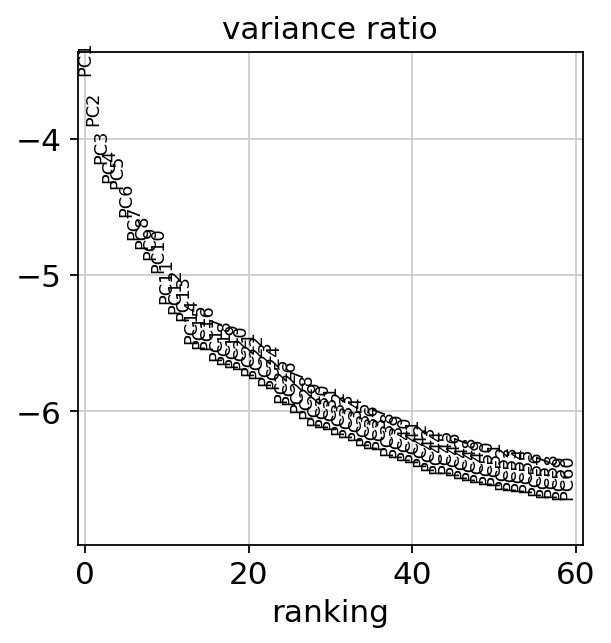

In [16]:
# make elbow plot to see variance contribution by each pc, choose inflection point
sc.pl.pca_variance_ratio(NR_clean, log=True, n_pcs=60)

### Export out the object that will be used for integration:

In [17]:
#at this point export out the object as the one we will use for integration (11min)
NR_clean.write_h5ad("NRclean_pre-int.h5ad", compression="gzip")

# Integration clean: 
#### want to perform integration after running PCA but before computing neighbor graph (perform on NRclean_pre-int.h5ad)

### Integration step was done by submitting a job. 

* Bashscript is named: _NR_bashscript-harmony-int.sh
* python script named: _NR-script-harmony-int.py

Ran with `sbatch _NR_bashscript-harmony-int.sh`

Bashscript: 
``` bash
#!/bin/bash
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=64
#SBATCH --mem=200G
#SBATCH --job-name=NR-IntegrationClean
#SBATCH --time=4:00:00
#SBATCH --partition=general
#SBATCH --account=a_kelvin_tuong
#SBATCH -o NR-IntegrationClean.output
#SBATCH -e NR-IntegrationClean.error

# export JAVA_CMD=/home/uqztuong/miniforge3/bin/java
source ~/.bashrc
mamba activate env
python3 _NR-script-harmony-int.py
```

Python script: 
``` python
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce

os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')

data_pre = sc.read_h5ad('/scratch/user/s4436039/scdata/Python_Integration_Sep/NRclean_pre-int.h5ad')

sce.pp.harmony_integrate(data_pre, 'integration_id', max_iter_harmony=200, verbose=True)

data_pre.write_h5ad("/scratch/user/s4436039/scdata/Python_Integration_Sep/NRclean_post-int.h5ad", compression="gzip")
```

### Converged after 3 iterations, took 1hr

# Read in data before/after integration and do UMAP:
* Perform neigborhood and UMAP on integrated and unintegrated data as a comparison:

In [6]:
#read in data
data_pre = sc.read_h5ad('NRclean_pre-int.h5ad')
data_post = sc.read_h5ad('NRclean_post-int.h5ad')

In [7]:
data_pre.obsm

AxisArrays with keys: X_pca

In [8]:
data_post.obsm

AxisArrays with keys: X_pca, X_pca_harmony

In [9]:
#check post int made new column with adjusted harmony PCs
'X_pca_harmony' in data_post.obsm

True

In [10]:
#assign the new PCs to the standard PCA slot for post int
data_post.obsm['X_pca'] = data_post.obsm['X_pca_harmony']

### Neighborhood graph:

In [11]:
## Computing neighbourhood graph - here UMAP
sc.pp.neighbors(data_pre, n_neighbors=10, n_pcs=60)

In [12]:
## Computing neighbourhood graph - here UMAP
sc.pp.neighbors(data_post, n_neighbors=10, n_pcs=60)

### UMAP (~10-15min each):

In [13]:
sc.tl.umap(data_pre, min_dist=0.3)  # 0.3 is personal preference

In [14]:
sc.tl.umap(data_post, min_dist=0.3)  # 0.3 is personal preference

In [15]:
#update unintegrated and integrated objects after UMAP (11min)
data_pre.write_h5ad("NRclean_unint.h5ad", compression="gzip")

In [16]:
data_post.write_h5ad("NRclean_post-int.h5ad", compression="gzip")

# Visualising Pre and Post integration

In [6]:
#read in data
data_pre = sc.read_h5ad('NRclean_unint.h5ad')
data_post = sc.read_h5ad('NRclean_post-int.h5ad')

### UMAP Visualisation:

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


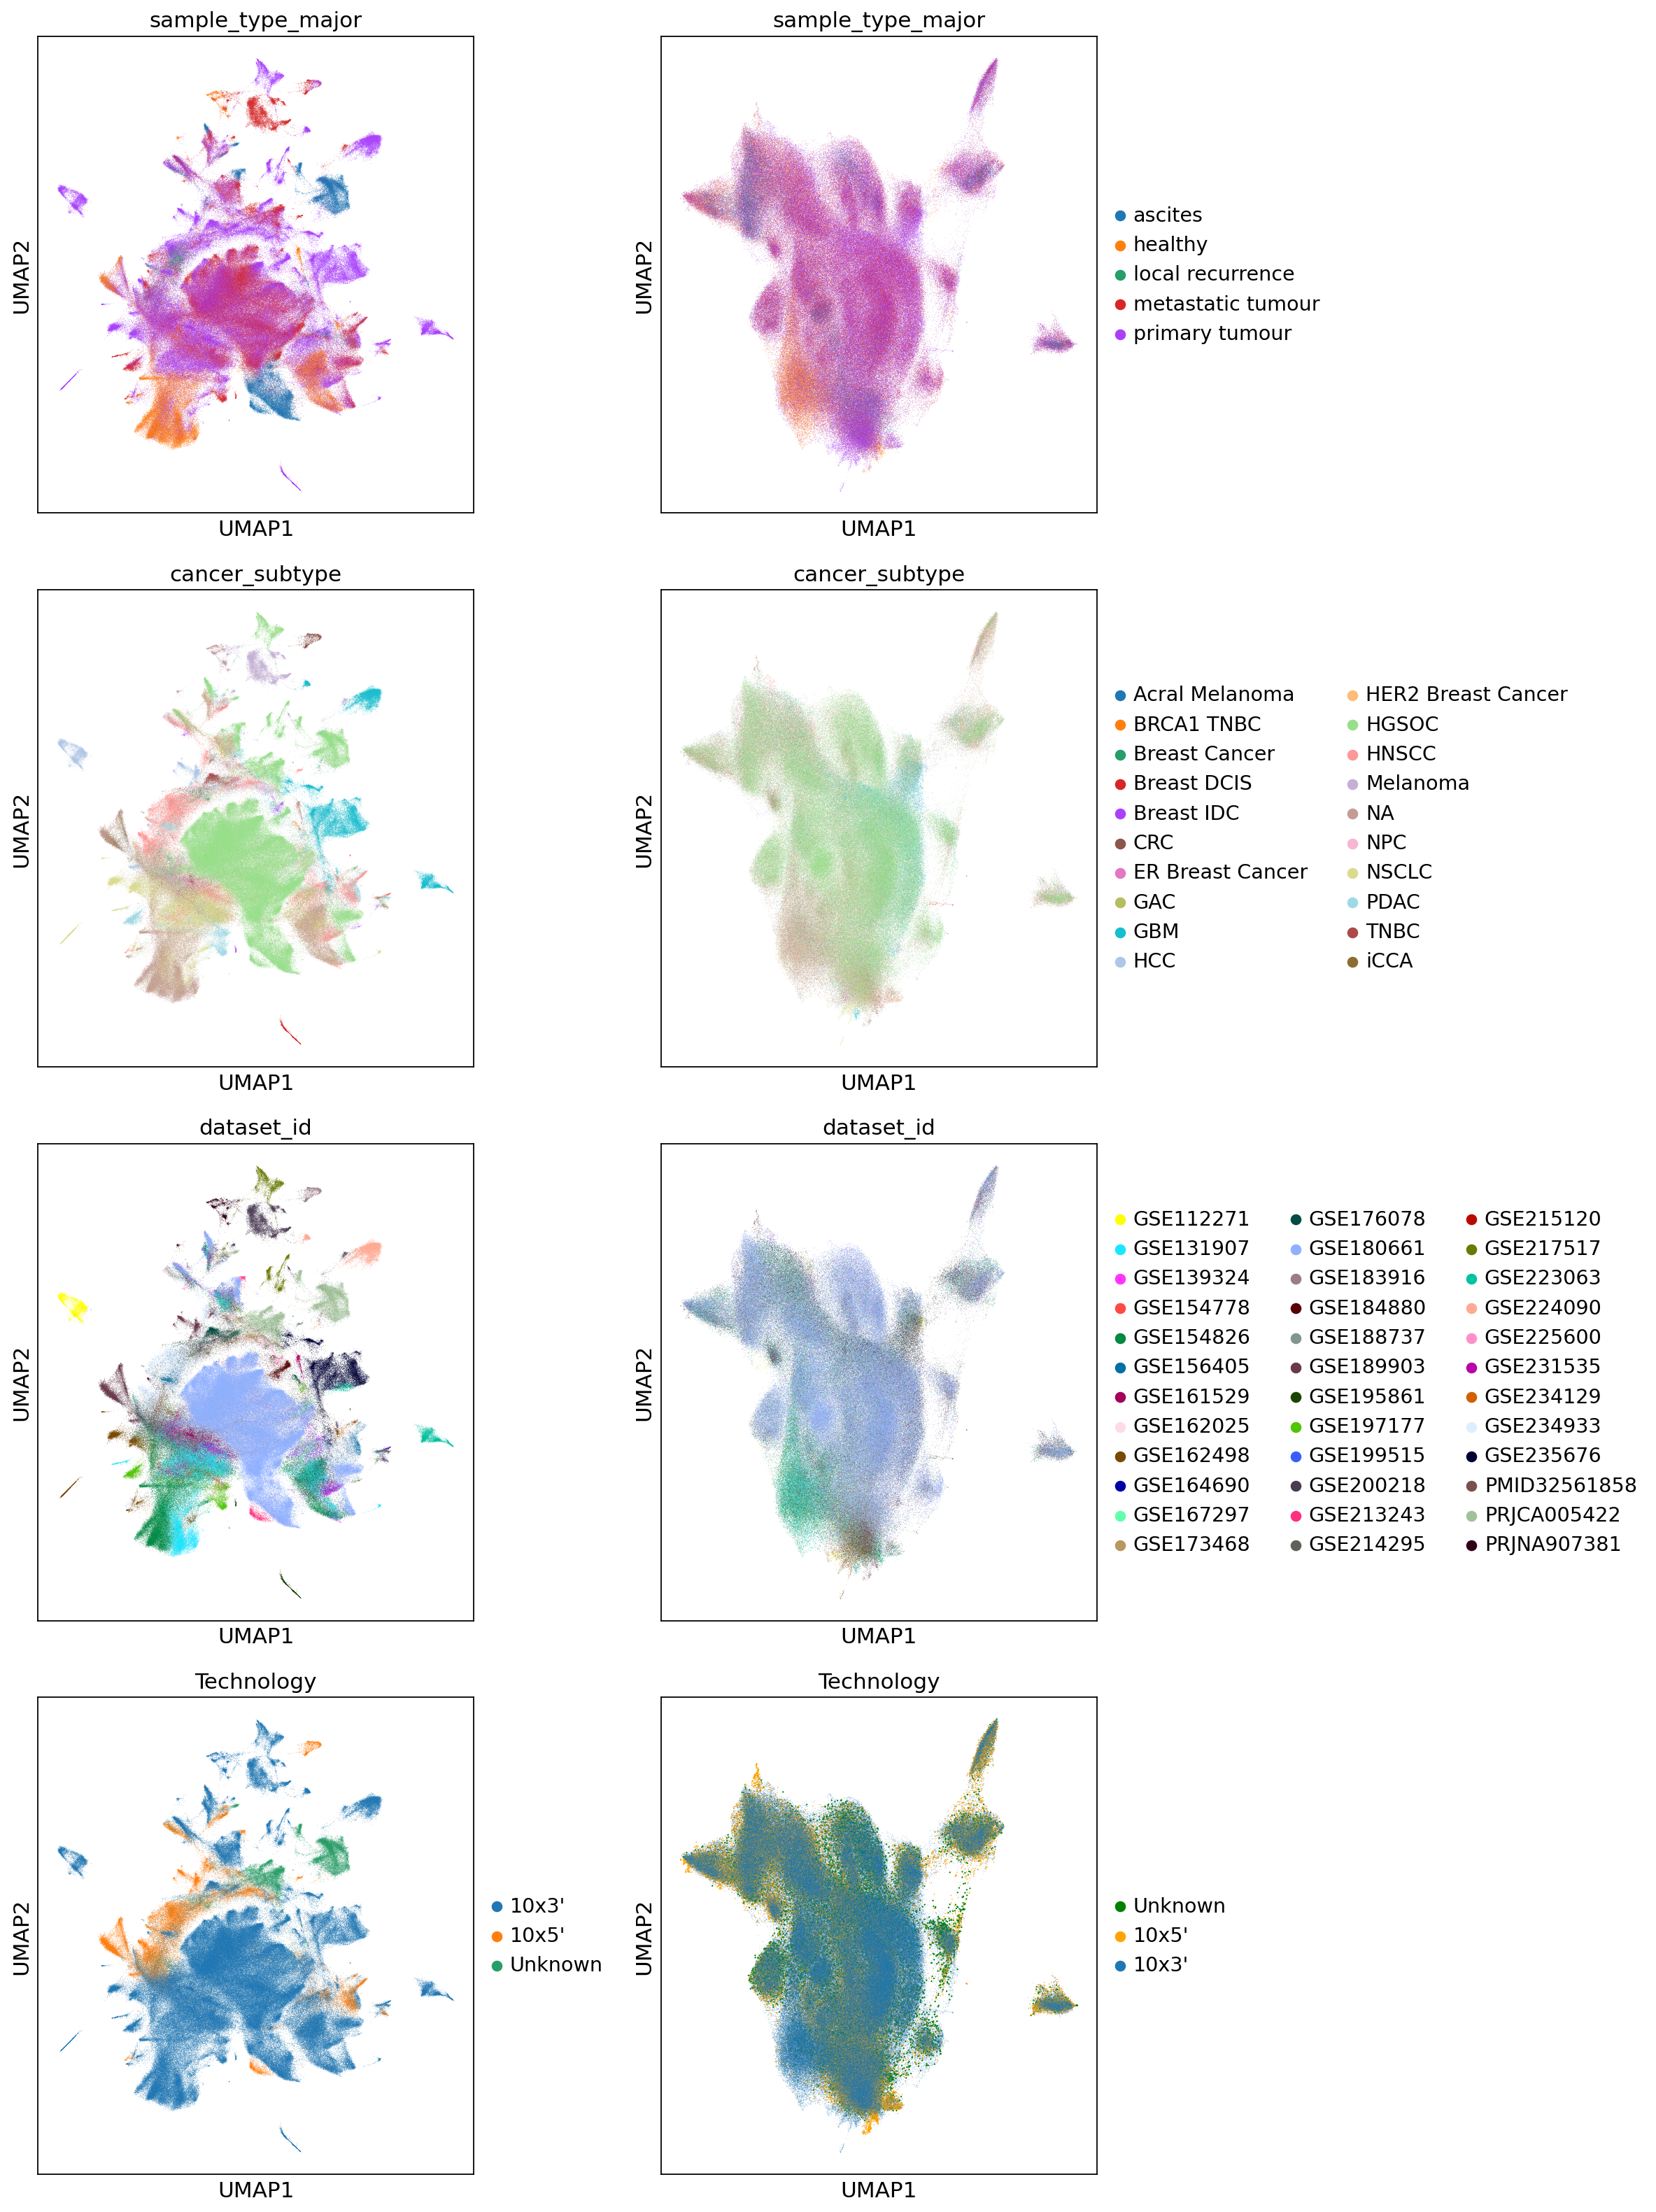

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))  # Create a figure with 4 rows and 2 columns

# Plot UMAP for data_pre
sc.pl.umap(
    data_pre,
    color=["sample_type_major"],
    ncols=1,
    ax=axes[0,0],  # Plot top left
    show=False,
    legend_loc=None  # Hide the legend
)

# Plot UMAP for data_post
sc.pl.umap(
    data_post,
    color=["sample_type_major"],
    ncols=1,
    ax=axes[0,1],  # Plot top right
    show=False
)

# Plot UMAP for data_pre
sc.pl.umap(
    data_pre,
    color=["cancer_subtype"],
    ncols=1,
    ax=axes[1,0],  # Plot second row left
    show=False,
    legend_loc=None  # Hide the legend
)

# Plot UMAP for data_post
sc.pl.umap(
    data_post,
    color=["cancer_subtype"],
    ncols=1,
    ax=axes[1,1],  # Plot second row right
    show=False
)

# Plot UMAP for data_pre
sc.pl.umap(
    data_pre,
    color=["dataset_id"],
    ncols=1,
    ax=axes[2,0],  # Plot third row left
    show=False,
    legend_loc=None  # Hide the legend
)

# Plot UMAP for data_post
sc.pl.umap(
    data_post,
    color=["dataset_id"],
    ncols=1,
    ax=axes[2,1],  # Plot third row right
    show=False
)

# Plot UMAP for data_pre
sc.pl.umap(
    data_pre,
    color=["Technology"],
    ncols=1,
    ax=axes[3,0],  # Plot fourth row left
    show=False
    #legend_loc=None  # Hide the legend
)

# split this plot in 3 so I can plot unknown and 5' on top of 3' otherwsise 3' just covers everything
sc.pl.umap(
    data_post[data_post.obs["Technology"] == "Unknown"],  # Filter for the "green" category
    color="Technology",
    ncols=1,
    ax=axes[3, 1],
    show=False,
    palette = {"Unknown": "green"}
)

sc.pl.umap(
    data_post[data_post.obs["Technology"] == "10x5'"],  # Filter for the "orange" category
    color="Technology",
    ncols=1,
    ax=axes[3, 1],
    show=False,
    palette = {"10x5'": "orange"}
)

sc.pl.umap(
    data_post[data_post.obs["Technology"] == "10x3'"],  # Filter for the "blue" category
    color="Technology",
    ncols=1,
    ax=axes[3, 1],
    show=False  
)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### colour by sex associated markers:
* Female: XIST, KDM5C, EIF1AX
* Male: RP4S1, SRY, CCX3Y, UTY, ZFY

* Most don't work, KDM5C and EIF1AX super dim

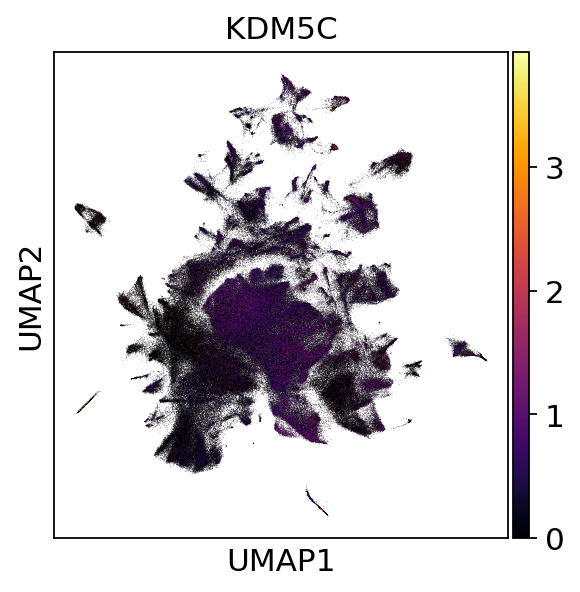

In [36]:
# Plot UMAP for data_pre
sc.pl.umap(
    data_pre,
    color=["KDM5C"],
    ncols=1,
    cmap="inferno"
)

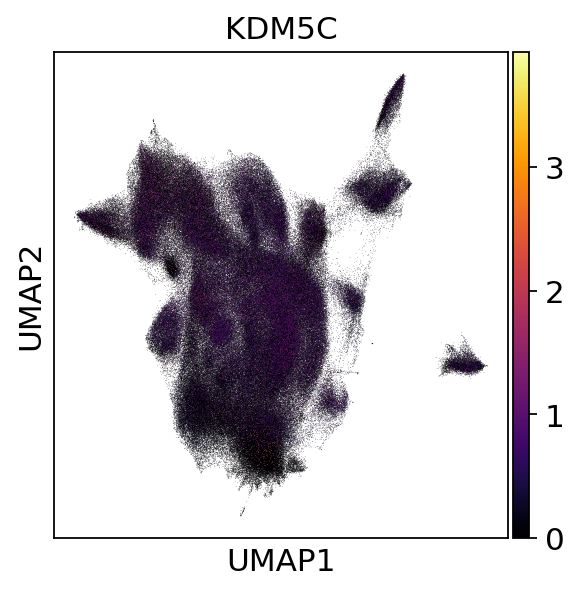

In [37]:
# Plot UMAP for data_post
sc.pl.umap(
    data_post,
    color=["KDM5C"],
    ncols=1,
    cmap="inferno"
)

### Colour by draft annotations:

In [ ]:
data_post.obs
#colour by leiden_DC and leiden_M

nCount_RNA  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                    20298.000000   
GSE215120_AM1_AAAGATGTCCAAATGC-1                     5574.000000   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                    17143.000000   
GSE215120_AM1_ACACTGAAGATCCCGC-1                     5912.000000   
GSE215120_AM1_ACACTGATCCACTGGG-1                    18333.000000   
...                                                          ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.499666   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.871771   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.766977   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.133310   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.476278   

                                                    nFeature_RNA sample_type  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                     3789.000000      tumour   
GSE215120_AM1_AAAGATGTCCAAATGC-1                     1721.000000      tumour   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                     2659.000000      tumour   
GSE215120_AM1_ACACTGAAGATCCCGC-1                     1374.000000      tumour   
GSE215120_AM1_ACACTGATCCACTGGG-1                     2845.000000      tumour   
...                                                          ...         ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -9.853381      Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    -10.337130      Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -8.292435      Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -8.758132      Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    -10.355681      Adnexa   

                                                       cancer_type  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                    Acral Melanoma   
GSE215120_AM1_AAAGATGTCCAAATGC-1                    Acral Melanoma   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                    Acral Melanoma   
GSE215120_AM1_ACACTGAAGATCCCGC-1                    Acral Melanoma   
GSE215120_AM1_ACACTGATCCACTGGG-1                    Acral Melanoma   
...                                                            ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   

                                                     patient_id  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                            AM1   
GSE215120_AM1_AAAGATGTCCAAATGC-1                            AM1   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                            AM1   
GSE215120_AM1_ACACTGAAGATCCCGC-1                            AM1   
GSE215120_AM1_ACACTGATCCACTGGG-1                            AM1   
...                                                         ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   

                                                                              sample_id  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                                GSE215120_Acral_MEL_AM1   
GSE215120_AM1_AAAGATGTCCAAATGC-1                                GSE215120_Acral_MEL_AM1   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                                GSE215120_Acral_MEL_AM1   
GSE215120_AM1_ACACTGAAGATCCCGC-1                                GSE215120_Acral_MEL_AM1   
GSE215120_AM1_ACACTGATCCACTGGG-1                                GSE215120_Acral_MEL_AM1   
...                                                                                 

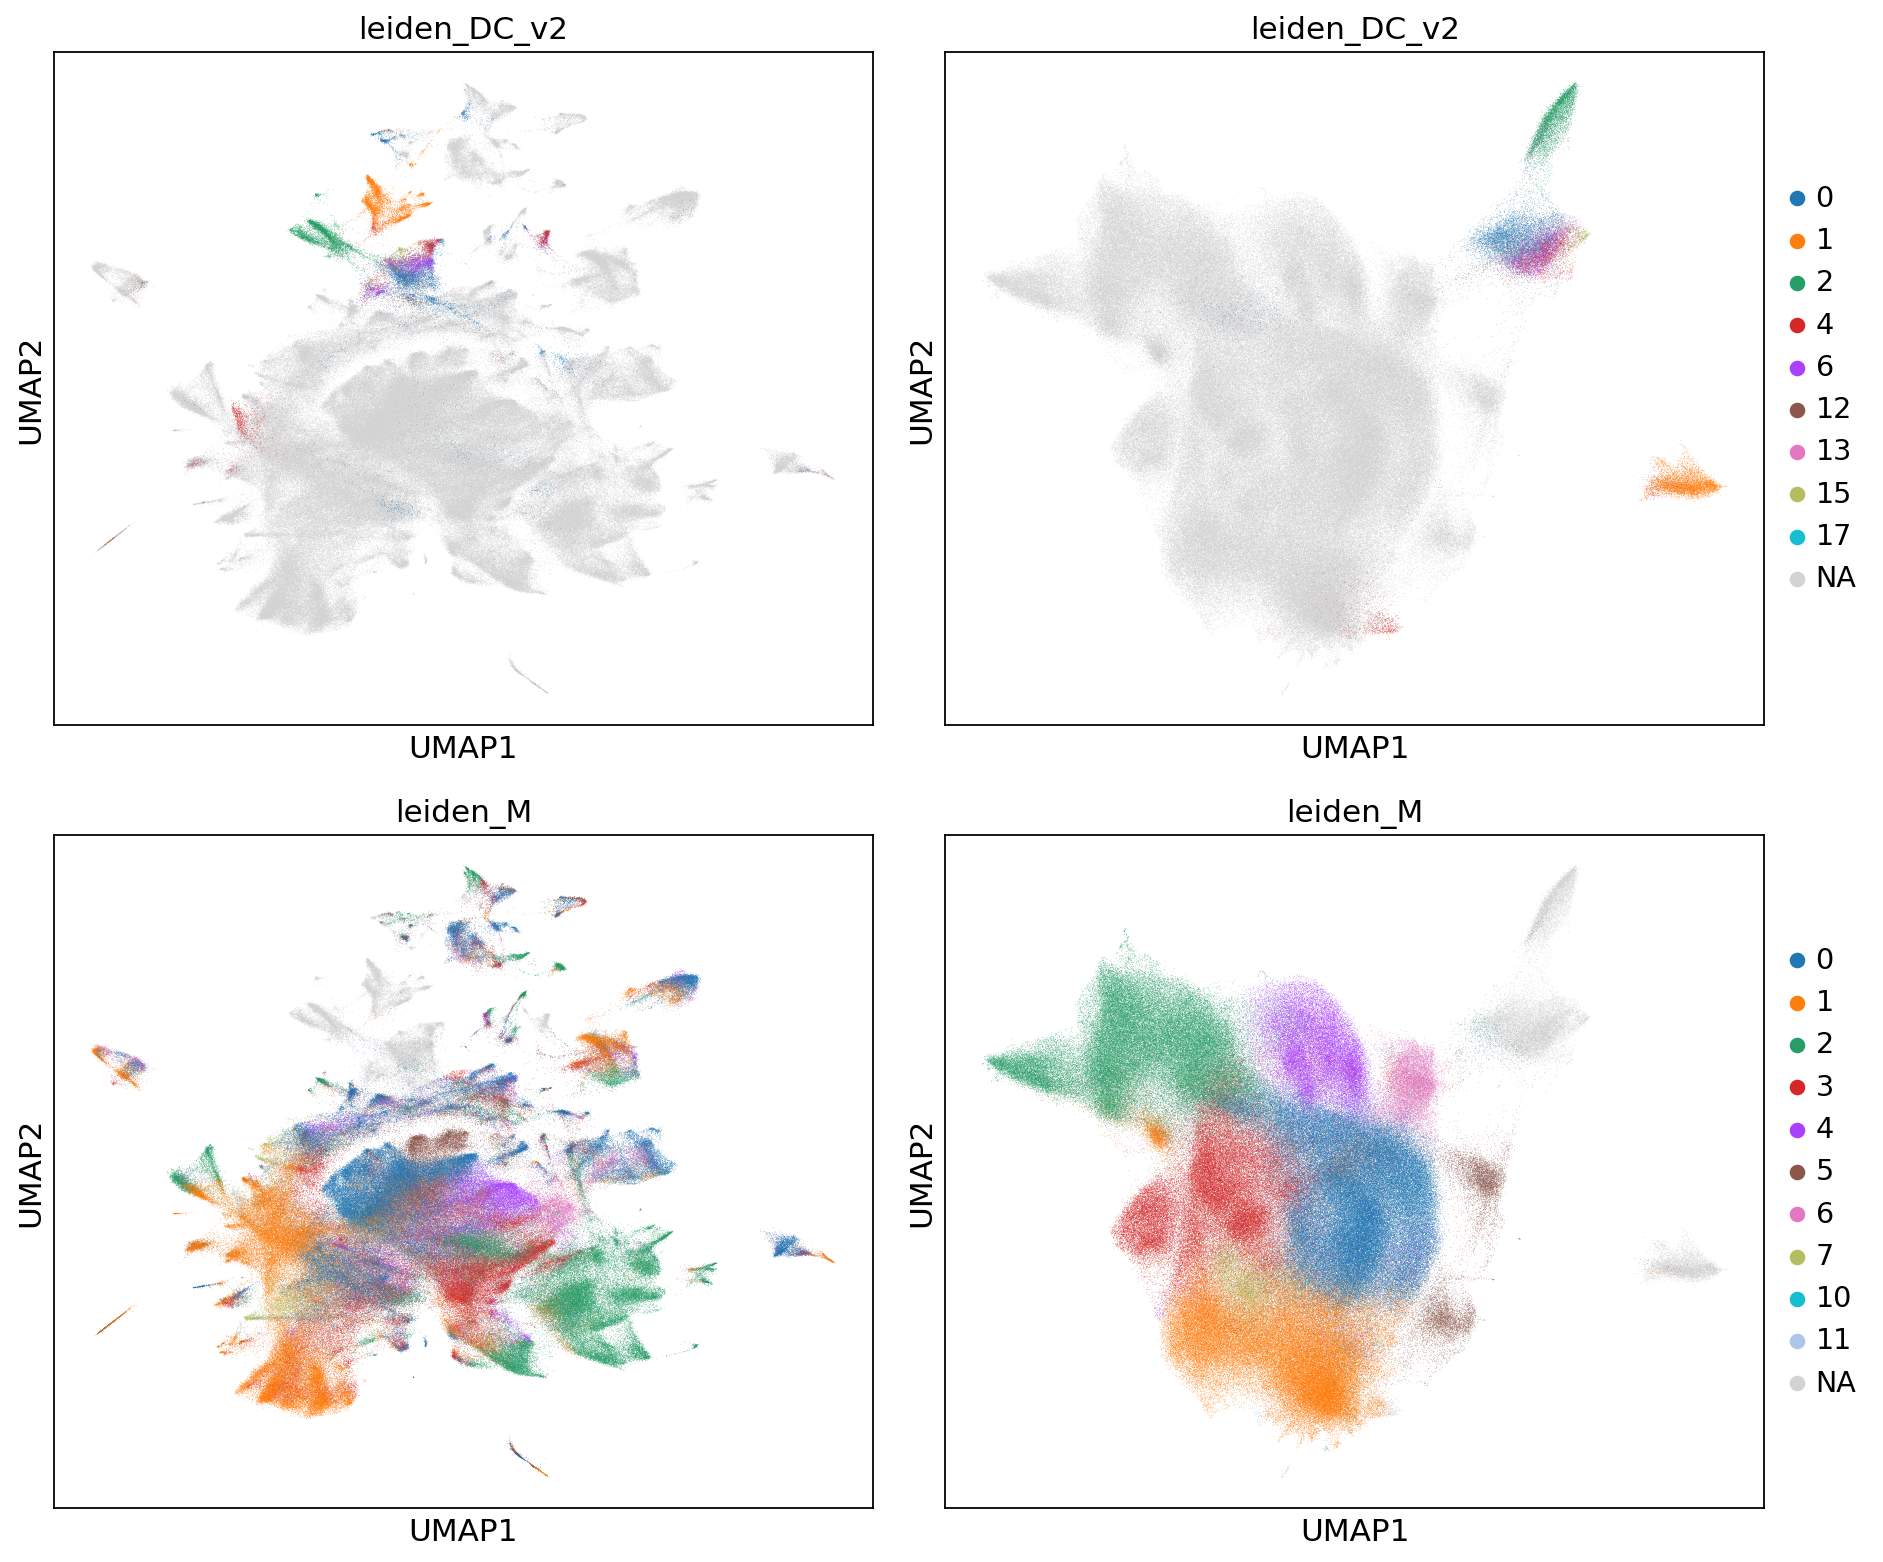

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a figure with 4 rows and 2 columns

# Plot UMAP for data_pre
sc.pl.umap(
    data_pre,
    color=["leiden_DC_v2"],
    ncols=1,
    ax=axes[0,0],  # Plot top left
    show=False,
    legend_loc=None  # Hide the legend
)

# Plot UMAP for data_post
sc.pl.umap(
    data_post,
    color=["leiden_DC_v2"],
    ncols=1,
    ax=axes[0,1],  # Plot top right
    show=False
)

# Plot UMAP for data_pre
sc.pl.umap(
    data_pre,
    color=["leiden_M"],
    ncols=1,
    ax=axes[1,0],  # Plot second row left
    show=False,
    legend_loc=None  # Hide the legend
)

# Plot UMAP for data_post
sc.pl.umap(
    data_post,
    color=["leiden_M"],
    ncols=1,
    ax=axes[1,1],  # Plot second row right
    show=False
)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()